In [9]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [39]:
mnist_train = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

mnist_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=64, shuffle=True)

In [4]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [120]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3),
            nn.Flatten(),
            nn.Linear(576,64),
            nn.ReLU(),
            nn.Linear(64,49),
            nn.ReLU(),
            nn.Flatten()
        )
        self.decode = nn.Sequential(
            nn.Unflatten(1, (1,7,7)),
            nn.ConvTranspose2d(1, 64, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 1, 6),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoding = self.encode(x)
        decoded = self.decode(encoding)
        return decoded

In [143]:
model = AutoEncoder().to(device)
print(model)

AutoEncoder(
  (encode): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=576, out_features=64, bias=True)
    (9): ReLU()
    (10): Linear(in_features=64, out_features=49, bias=True)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
  )
  (decode): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(1, 7, 7))
    (1): ConvTranspose2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU()
    (7): Conv2

In [129]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, _) in enumerate(dataloader):
        X = X.to(device)

        pred = model(X)
        loss = loss_fn(pred, X)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch & 100 == 0:
            loss = loss.item()
            current = (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]", end='\r')

In [126]:
def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()

    test_loss /= num_batches
    print(F"Average Loss: {test_loss:>8f}")


In [144]:
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [150]:
epochs = 25

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    print("")

    train_loop(mnist_train_loader, model, loss, optimizer)
    print("")

Epoch 0

loss: 0.017457 [59136/60000]
Epoch 1

loss: 0.016735 [59136/60000]
Epoch 2

loss: 0.016354 [59136/60000]
Epoch 3

loss: 0.015778 [59136/60000]
Epoch 4

loss: 0.016682 [59136/60000]
Epoch 5

loss: 0.013187 [59136/60000]
Epoch 6

loss: 0.014123 [59136/60000]
Epoch 7

loss: 0.015614 [59136/60000]
Epoch 8

loss: 0.013020 [59136/60000]
Epoch 9

loss: 0.014419 [59136/60000]
Epoch 10

loss: 0.015255 [59136/60000]
Epoch 11

loss: 0.014482 [59136/60000]
Epoch 12

loss: 0.014812 [59136/60000]
Epoch 13

loss: 0.013710 [59136/60000]
Epoch 14

loss: 0.013058 [59136/60000]
Epoch 15

loss: 0.013014 [59136/60000]
Epoch 16

loss: 0.013207 [59136/60000]
Epoch 17

loss: 0.013054 [59136/60000]
Epoch 18

loss: 0.013503 [59136/60000]
Epoch 19

loss: 0.014140 [59136/60000]
Epoch 20

loss: 0.012510 [59136/60000]
Epoch 21

loss: 0.013728 [59136/60000]
Epoch 22

loss: 0.013547 [59136/60000]
Epoch 23

loss: 0.012105 [59136/60000]
Epoch 24

loss: 0.013503 [59136/60000]


In [151]:
test_b, _ = next(iter(mnist_test_loader))
test_b = test_b.to(device)
test_pred = None
with torch.no_grad():
    test_pred = model(test_b)

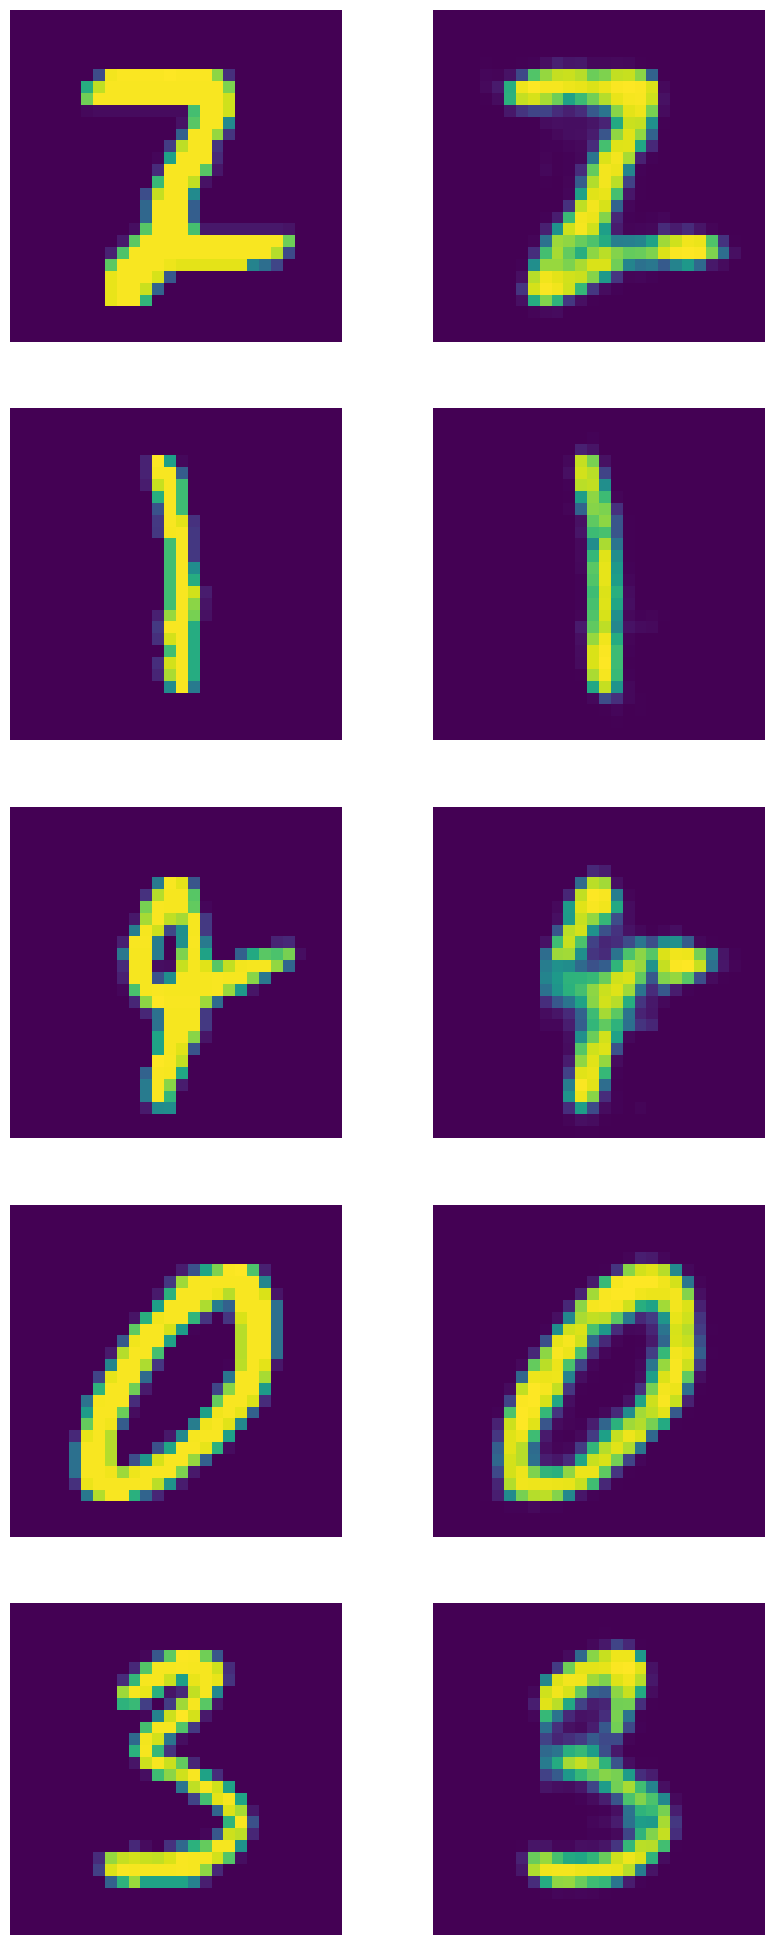

In [152]:
num_to_show = 5

test_b = test_b.to("cpu")
test_pred = test_pred.to("cpu")

fig, axs = plt.subplots(num_to_show, 2, figsize=(10, 5*num_to_show))
for i in range(num_to_show):
    axs[i][0].imshow(test_b.numpy()[i,0,:,:])
    axs[i][0].set_axis_off()
    axs[i][1].imshow(test_pred.numpy()[i,0,:,:])
    axs[i][1].set_axis_off()